In [1]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
#import segmentation_models as sm
import tensorflow as tf
#from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import load_model
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
from typing import Tuple

2023-02-24 12:01:54.209579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 12:01:55.180105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/elena/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-24 12:01:55.180158: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-24 12:01:55.380623: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already b

Segmentation Models: using `keras` framework.


In [2]:
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (0,0,0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [3]:

# loading image data...
def image_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path)
        image = resize_with_pad(image, (sx, sy)) #Mantengo la giusta proporzione e aggiungo del padding
        image_dataset.append(image)
    return image_dataset

In [4]:
# loading mask data...
def mask_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path, 0)
        image = resize_with_pad(image, (sx, sy))
        image_dataset.append(image)
    return image_dataset

In [5]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "car-segmentation", "images")
masks_folder = os.path.join("..", "car-segmentation", "masks")
n_classes = 5 # class for segmentation
size_x = 144
size_y = 144

image_dataset = image_loader(img_folder,size_x,size_y) # real images...
mask_dataset = mask_loader(masks_folder,size_x,size_y) # masked images...
image_dataset = np.array(image_dataset)
#image_dataset = np.expand_dims(image_dataset, axis = 3) # per creare la giusta struttura
mask_dataset = np.array(mask_dataset)
#Espando la dimensione anche della maschera
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)

#Normalize images (pixel diventano tra 0 e 1)
image_dataset = image_dataset /255. 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [6]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
print("image Shape:")   
print(X_train.shape)
print(X_test.shape)
print("mask shape:")
print(y_train.shape)
print(y_test.shape)
print(f"Dimensione training set: {len(X_train)}\nDimensione val set: {len(X_val)}\nDimensione test set: {len(X_test)}")
     

image Shape:
(1080, 144, 144, 3)
(338, 144, 144, 3)
mask shape:
(1080, 144, 144, 1)
(338, 144, 144, 1)
Dimensione training set: 1080
Dimensione val set: 270
Dimensione test set: 338


In [7]:
#One hot encoding

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))


In [8]:
#Load previously saved model
from keras.models import load_model
path = os.path.join("..", "PSP_144x144_p2.hdf5")
loss = sm.losses.bce_jaccard_loss
model = load_model(path,custom_objects={'binary_crossentropy_plus_jaccard_loss': loss,'iou_score': sm.metrics.iou_score, 'f1-score':sm.metrics.FScore(threshold=0.5)}) 
model.summary()




2023-02-24 12:05:05.799653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/elena/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-24 12:05:05.801013: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-24 12:05:05.801988: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (proffiterol): /proc/driver/nvidia/version does not exist
2023-02-24 12:05:05.804424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 144, 144, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 150, 150, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 72, 72, 64)   9408        ['zero_padding2d[0][0]']   

/tmp/ipykernel_82826/2093057692.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_data = log_data.append(log_data2)


Accuracy ottenuta 0.9881771206855774, Loss ottenuta: 0.1562320291996002
Val accuracy: 0.979426383972168, Val loss: 0.2298108488321304


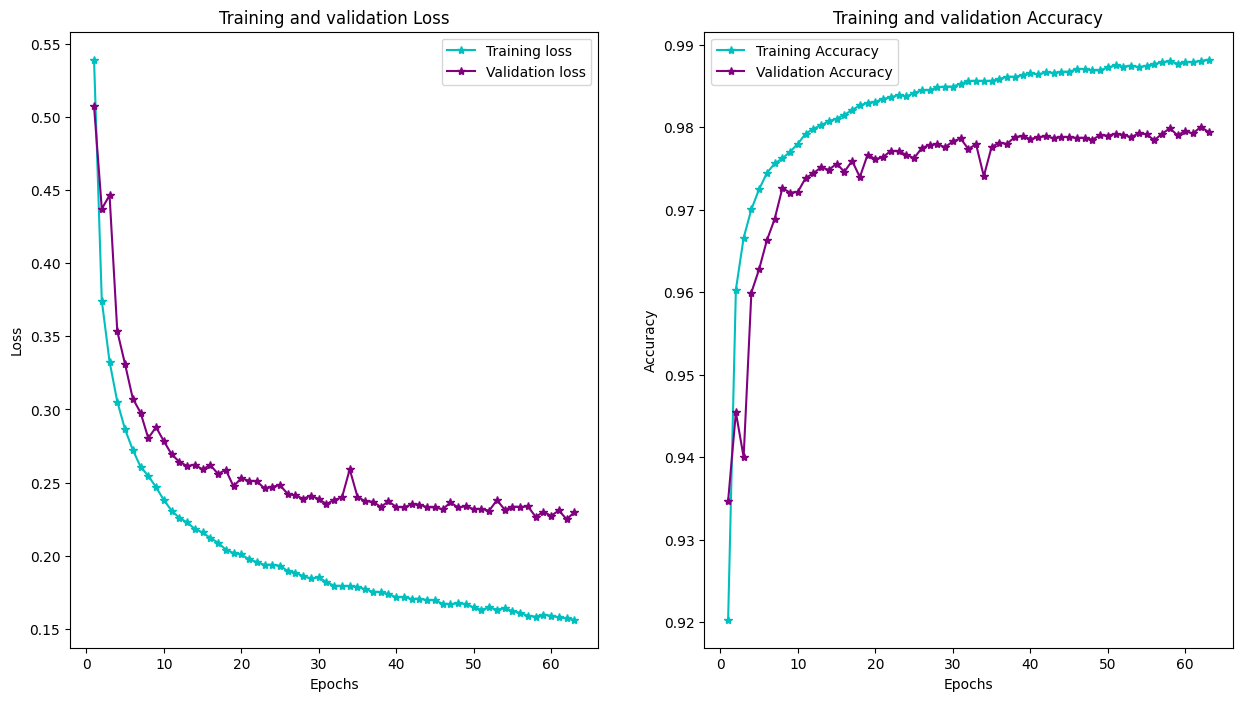

In [9]:
import pandas as pd

log_data = pd.read_csv('PSP_144x144.log', sep=',', engine='python')
log_data2 = pd.read_csv('PSP_144x144_p2.log', sep=',', engine='python')
log_data = log_data.append(log_data2)

patience = 3

#plot the training and validation accuracy and loss at each epoch
loss = log_data['loss'].iloc[:-patience]
val_loss = log_data['val_loss'].iloc[:-patience]
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'c', marker="*", label='Training loss')
plt.plot(epochs, val_loss, 'purple', marker="*", label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


acc = log_data['accuracy'].iloc[:-patience]
val_acc = log_data['val_accuracy'].iloc[:-patience]
ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, acc, 'c',  marker="*", label='Training Accuracy')
plt.plot(epochs, val_acc, 'purple', marker="*", label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
print(f"Accuracy ottenuta {acc.iloc[-1]}, Loss ottenuta: {loss.iloc[-1]}\nVal accuracy: {val_acc.iloc[-1]}, Val loss: {val_loss.iloc[-1]}")


In [10]:
from keras import backend as K
K.clear_session()

#Predizione del modello sul dataset test
y_pred=model.predict(X_test)
#Argmax controlla il valore maggiore dell'asse indicato e prende solo quello
y_pred_argmax=np.argmax(y_pred, axis=3)


2023-02-24 12:05:10.243468: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84105216 exceeds 10% of free system memory.
2023-02-24 12:05:11.400373: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42467328 exceeds 10% of free system memory.
2023-02-24 12:05:11.557786: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 44859392 exceeds 10% of free system memory.
2023-02-24 12:05:12.382897: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 21233664 exceeds 10% of free system memory.
2023-02-24 12:05:12.383400: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 21233664 exceeds 10% of free system memory.


11/11 [==============================] - 15s 1s/step


In [11]:
#Controllo effettivamente il modello sul validation set
val_res = model.evaluate(X_val,y_val_cat)
print(f"Loss ottenuta sul test: {val_res[0]}\nAccuracy ottenuta sul test: {val_res[1]}")

#Controllo i risultati sul test set
results = model.evaluate(X_test, y_test_cat)
print(f"Loss ottenuta sul test: {results[0]}\nAccuracy ottenuta sul test: {results[1]}")


9/9 [==============================] - 12s 1s/step - loss: 2.1801 - iou_score: 0.1529 - f1-score: 0.1733 - accuracy: 0.7655
Loss ottenuta sul test: 2.180122137069702
Accuracy ottenuta sul test: 0.15285076200962067
11/11 [==============================] - 13s 1s/step - loss: 2.2117 - iou_score: 0.1520 - f1-score: 0.1727 - accuracy: 0.7607
Loss ottenuta sul test: 2.2117233276367188
Accuracy ottenuta sul test: 0.15196198225021362


In [12]:
#Per vedere un'unica classe alla volta -> y_pred[n_image][:,:,classe]
classi = ['background', 'car', 'wheel', 'lights', 'windows']
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
#si può calcolare la mean IoU per ogni classe
# target_class_ids indicates the class/classes you want to calculate IoU on
for i in range(5):
    loss = tf.keras.metrics.IoU(num_classes=5, target_class_ids=[i])
    loss.update_state(y_test, y_pred_argmax)
    print("Risultato per la classe", classi[i] ,": ",loss.result().numpy())

Mean IoU = 0.15214711
Risultato per la classe background :  0.7607356
Risultato per la classe car :  0.0
Risultato per la classe wheel :  0.0
Risultato per la classe lights :  0.0
Risultato per la classe windows :  0.0


1/1 [==============================] - 0s 61ms/step


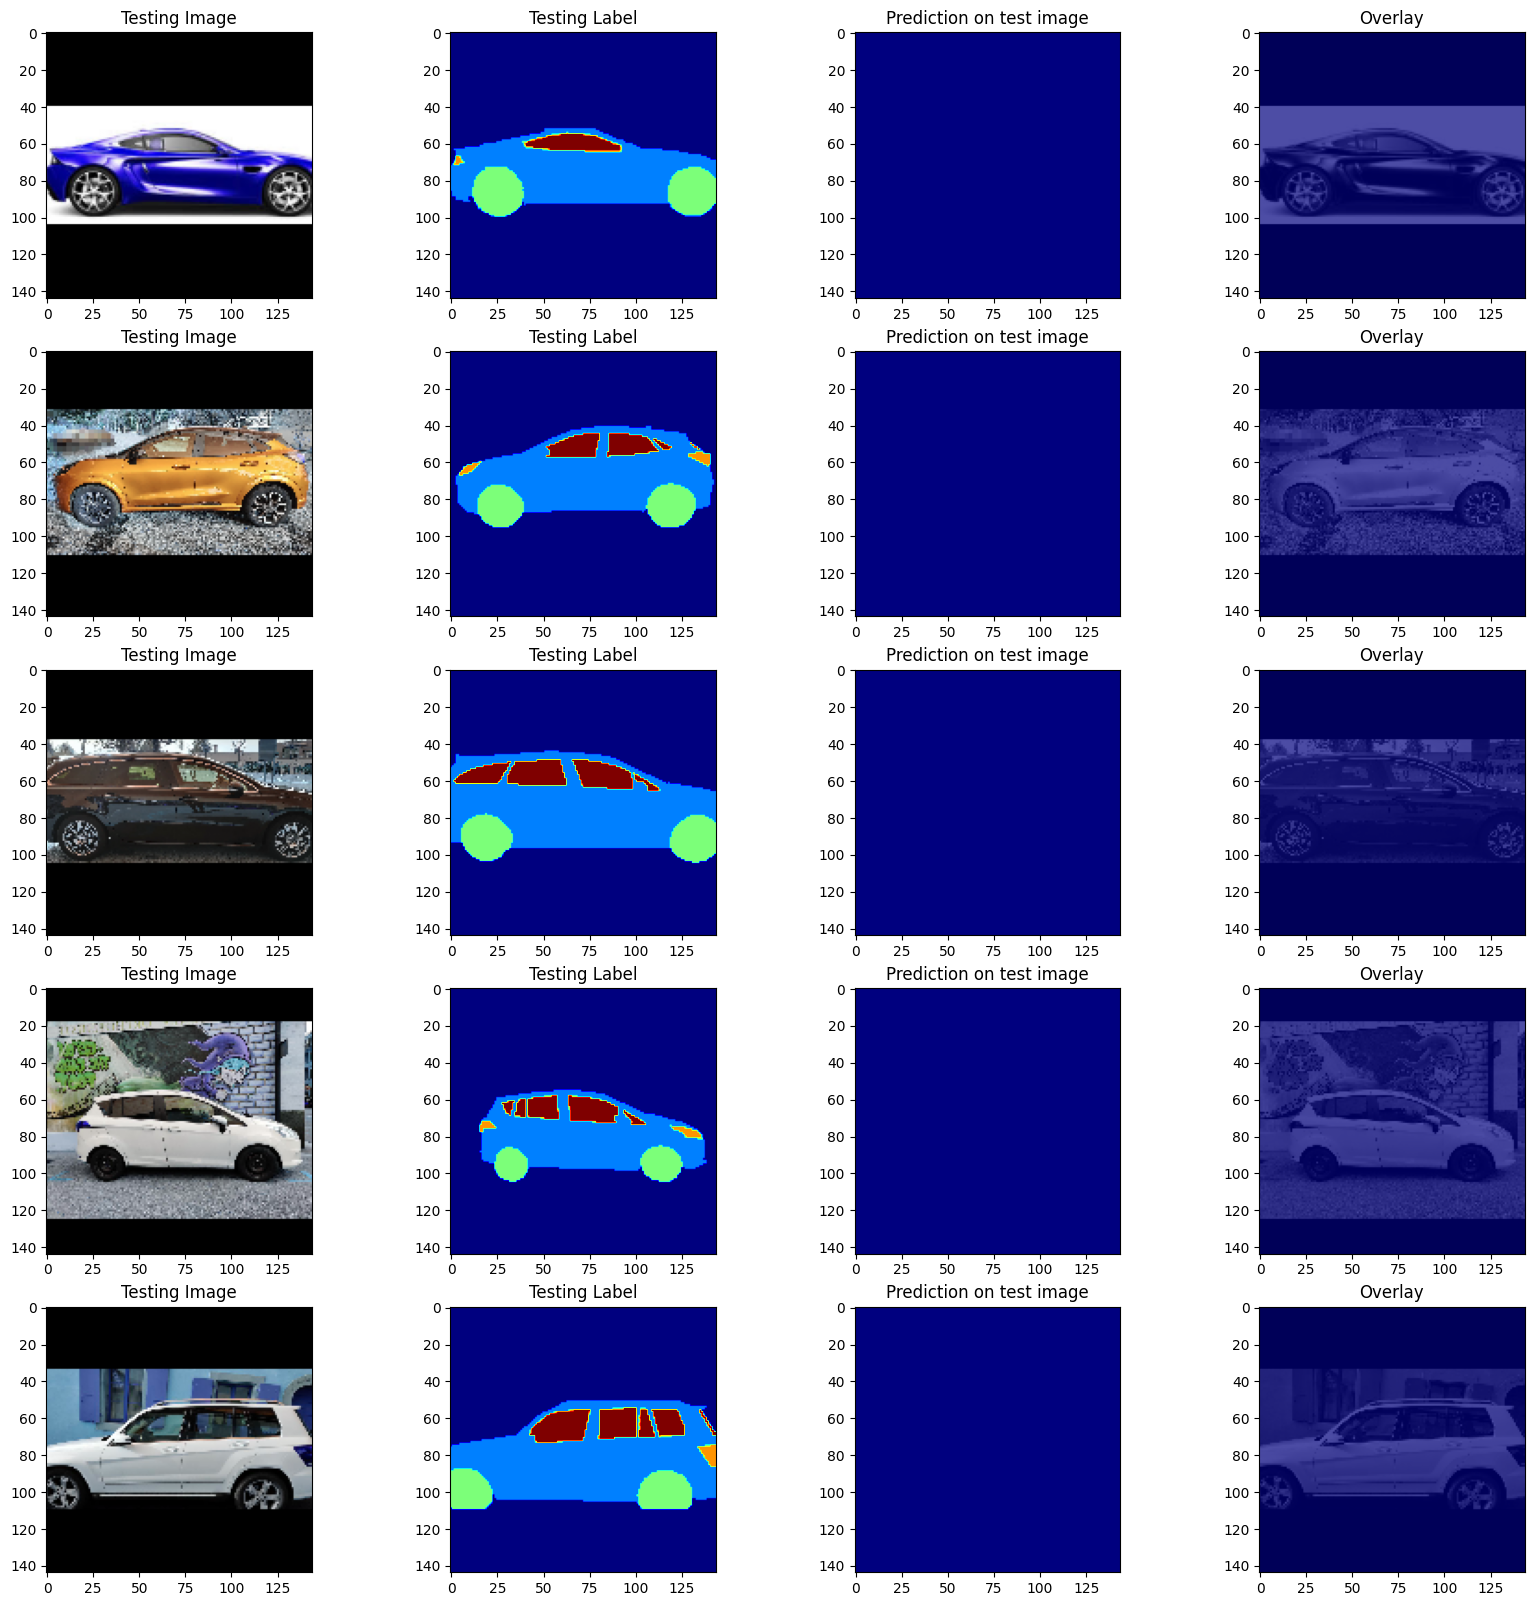

In [13]:
import random

fig = plt.figure(figsize=(20, 20))

for i in range(5):
    test_img_number = random.randint(0, len(X_test)-1)
    test_img = X_test[test_img_number]
    test_img_input = np.expand_dims(test_img,0)
    ground_truth=y_test[test_img_number]
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    ax = fig.add_subplot(5,4,i*4+1)
    plt.title('Testing Image')
    plt.imshow(test_img, cmap='gray')
    
    ax = fig.add_subplot(5,4,i*4+2)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+3)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+4)
    plt.title('Overlay')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.imshow(predicted_img, cmap='jet', alpha=0.7)
    #plt.show()